# Aplicando métodos de Machine Learning para interpolação de dados climáticos em determinada longitude

Esse notebook foi criado com o objetivo de criar um modelo interpolador dos dados de temperatura obtidos através da API **WeatherStack**.
Com os dados de estações climatológicas dispostas em determinadas latitudes, é possível completar dados em latitudes faltantes;
O modelo leva em conta: *latitude*, *velocidade do vento*, *ângulo do vento*, *pressão*, *índice de precipitação*, *umidade*, *cobertura de núvens*, *índice de radiação ultravioleta* e *visibilidade*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 97404

### Importando o DataFrame:

In [2]:
df = pd.read_csv("Final Data.csv", index_col="Unnamed: 0")
df = df.convert_dtypes()

features = ["latitude", "wind_speed", "wind_degree", "pressure", "precip", "humidity", "cloudcover", "uv_index", "visibility"]
targets = ["temperature", "feelslike"]
target1 = ["temperature"]
target2 = ["feelslike"]

In [3]:
from pandas.api.types import is_numeric_dtype

def remove_not_numbers(df):
    df_c = df.copy()
    for i in df_c.columns:
        if is_numeric_dtype(df_c[i]) == False or str(df_c[i].dtype) == 'boolean':
            #print(i, "removido")
            df_c = df_c.drop([i], axis=1)
        else:
            continue
    return df_c

In [4]:
df = remove_not_numbers(df)

### Plot utilizando o mapa mundi

Text(0.5, 1.0, 'Temperatura [°C] x latitude')

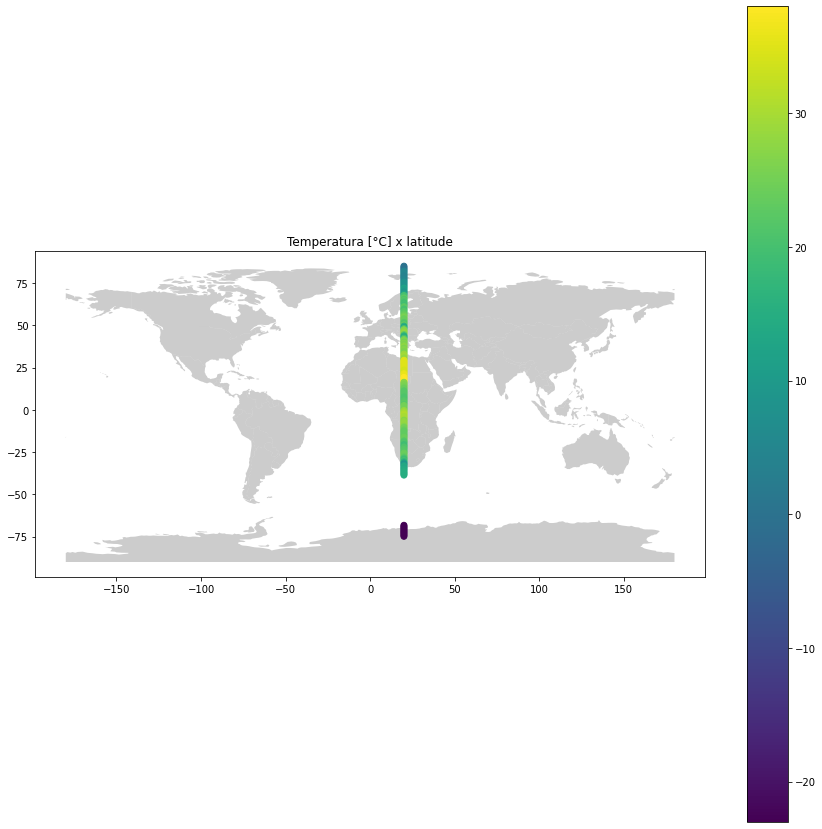

In [5]:
import geopandas as gpd

lista_lon = [20 for i in range(df.shape[0])]
df_lon = pd.DataFrame(lista_lon, index=df.index)

geometry = gpd.points_from_xy(df_lon[0], df["latitude"])
geo_df = gpd.GeoDataFrame(
    df[["temperature", "feelslike"]], geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(15, 15))
world.plot(ax=ax, alpha=0.4, color="gray")
geo_df.plot(column="temperature", ax=ax, legend=True)
plt.title("Temperatura [°C] x latitude")

Analisando, com embasamento climatológico, as temperaturas fazem sentido:
- São menores nos polos;
- São maiores na linha do equador e na região do trópico de Câncer, onde está localizado o deserto do Saara;
- Em comparação com regiões continentais, oceanos possuem menor temperatura.

### Plotando Temperatura/Feelslike [°C] x Latitude

<Figure size 1800x1200 with 0 Axes>

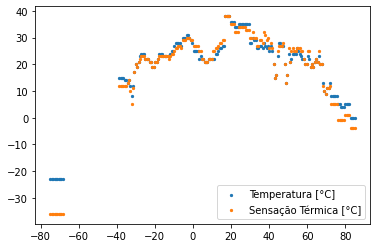

<Figure size 1800x1200 with 0 Axes>

In [6]:
plt.scatter(list(df["latitude"]), list(df["temperature"]), s=5)
plt.scatter(list(df["latitude"]), list(df["feelslike"]), s=5)
plt.legend(["Temperatura [°C]", "Sensação Térmica [°C]"])

plt.figure(dpi=300)

Nota-se que os dados das menores latitudes (que correspondem à Antartida) possuem valores muito distoantes do resto dos valores - podem ser considerados outliers. É interessante remover esses valores para melhor funcionamento do modelo, portanto.

<Figure size 1800x1200 with 0 Axes>

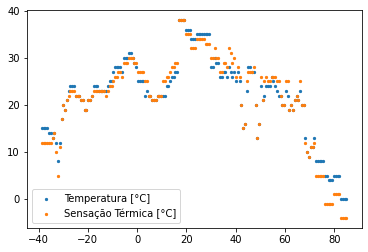

<Figure size 1800x1200 with 0 Axes>

In [7]:
df_outlierdrop = df.iloc[0:172].copy()

plt.scatter(list(df_outlierdrop["latitude"]), list(df_outlierdrop["temperature"]), s=5)
plt.scatter(list(df_outlierdrop["latitude"]), list(df_outlierdrop["feelslike"]), s=5)
plt.legend(["Temperatura [°C]", "Sensação Térmica [°C]"])
plt.figure(dpi=300)

### Análise da descrição dos DataFrames

In [8]:
df.describe()

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,17.941374,14.274725,171.538462,1010.642857,0.297253,55.851648,30.406593,3.395604,9.527473,19.461538,18.467033
std,41.127445,9.245057,102.671100,3.630583,1.486381,30.573794,33.688524,2.822088,1.593084,13.197445,16.167169
min,-74.800000,4.000000,1.000000,1002.000000,0.000000,8.000000,0.000000,1.000000,2.000000,-23.000000,-36.000000
25%,-13.125000,7.250000,102.500000,1009.000000,0.000000,19.000000,0.000000,1.000000,10.000000,15.000000,14.250000
50%,19.520000,13.000000,163.000000,1011.000000,0.000000,61.000000,12.000000,1.000000,10.000000,22.500000,23.000000
75%,52.230000,18.000000,264.500000,1013.000000,0.000000,81.500000,54.750000,6.000000,10.000000,27.000000,27.000000
max,84.940000,51.000000,358.000000,1022.000000,13.500000,100.000000,100.000000,9.000000,10.000000,38.000000,38.000000


In [9]:
df_outlierdrop.describe()

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,23.143198,13.360465,174.476744,1011.145349,0.314535,55.610465,29.500000,3.534884,9.500000,21.930233,21.633721
std,35.983004,8.669922,104.879739,3.054444,1.527437,31.438132,34.441832,2.841619,1.634783,8.531731,9.648175
min,-38.600000,4.000000,1.000000,1005.000000,0.000000,8.000000,0.000000,1.000000,2.000000,0.000000,-4.000000
25%,-7.770000,7.000000,99.250000,1009.000000,0.000000,18.000000,0.000000,1.000000,10.000000,19.000000,19.000000
50%,23.130000,12.000000,167.500000,1011.000000,0.000000,68.000000,10.000000,2.000000,10.000000,23.000000,23.000000
75%,54.040000,17.000000,265.000000,1013.000000,0.000000,82.000000,57.500000,6.000000,10.000000,27.000000,28.000000
max,84.940000,51.000000,358.000000,1022.000000,13.500000,100.000000,100.000000,9.000000,10.000000,38.000000,38.000000


Percebe-se a diferença na média/desvio padrão dos valores de temperatura e sensação térmica, para uma melhor previsão, o dataframe a ser utilizado não conterá os dados da Antártida.

*A perda de 10 dados não acarretará em um prejuízo significativo.*

In [10]:
# Portanto, podemos dizer que:
df = df_outlierdrop

### Normalizando o dataframe
A fim de manter a ordem de grandeza dos dados semelhante:

In [11]:
df.columns

Index(['latitude', 'wind_speed', 'wind_degree', 'pressure', 'precip',
       'humidity', 'cloudcover', 'uv_index', 'visibility', 'temperature',
       'feelslike'],
      dtype='object')

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), index=df.index.copy(), columns=df.columns.copy())

In [13]:
df_norm

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
7,1.000000,0.212766,0.453782,1.000000,0.0,0.782609,0.05,0.000,1.0,0.000000,0.000000
8,0.994172,0.212766,0.453782,1.000000,0.0,0.782609,0.05,0.000,1.0,0.000000,0.000000
9,0.988263,0.212766,0.453782,1.000000,0.0,0.782609,0.05,0.000,1.0,0.000000,0.000000
10,0.982435,0.212766,0.453782,1.000000,0.0,0.782609,0.05,0.000,1.0,0.000000,0.000000
11,0.976607,0.510638,0.302521,0.470588,0.0,0.782609,0.37,0.000,1.0,0.131579,0.119048
...,...,...,...,...,...,...,...,...,...,...,...
174,0.023474,0.659574,0.756303,0.411765,0.0,0.728261,0.10,0.000,1.0,0.368421,0.380952
175,0.016999,0.659574,0.739496,0.352941,0.0,0.728261,0.08,0.375,1.0,0.394737,0.380952
176,0.011332,0.659574,0.739496,0.352941,0.0,0.728261,0.08,0.375,1.0,0.394737,0.380952
177,0.005666,0.659574,0.739496,0.352941,0.0,0.728261,0.08,0.375,1.0,0.394737,0.380952


In [14]:
df

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
7,84.94,14,163,1022,0.0,80,5,1,10,0,-4
8,84.22,14,163,1022,0.0,80,5,1,10,0,-4
9,83.49,14,163,1022,0.0,80,5,1,10,0,-4
10,82.77,14,163,1022,0.0,80,5,1,10,0,-4
11,82.05,28,109,1013,0.0,80,37,1,10,5,1
...,...,...,...,...,...,...,...,...,...,...,...
174,-35.7,35,271,1012,0.0,75,10,1,10,14,12
175,-36.5,35,265,1011,0.0,75,8,4,10,15,12
176,-37.2,35,265,1011,0.0,75,8,4,10,15,12
177,-37.9,35,265,1011,0.0,75,8,4,10,15,12


#### Conseguimos, assim, fazer o pair plot e a matirz de covariância

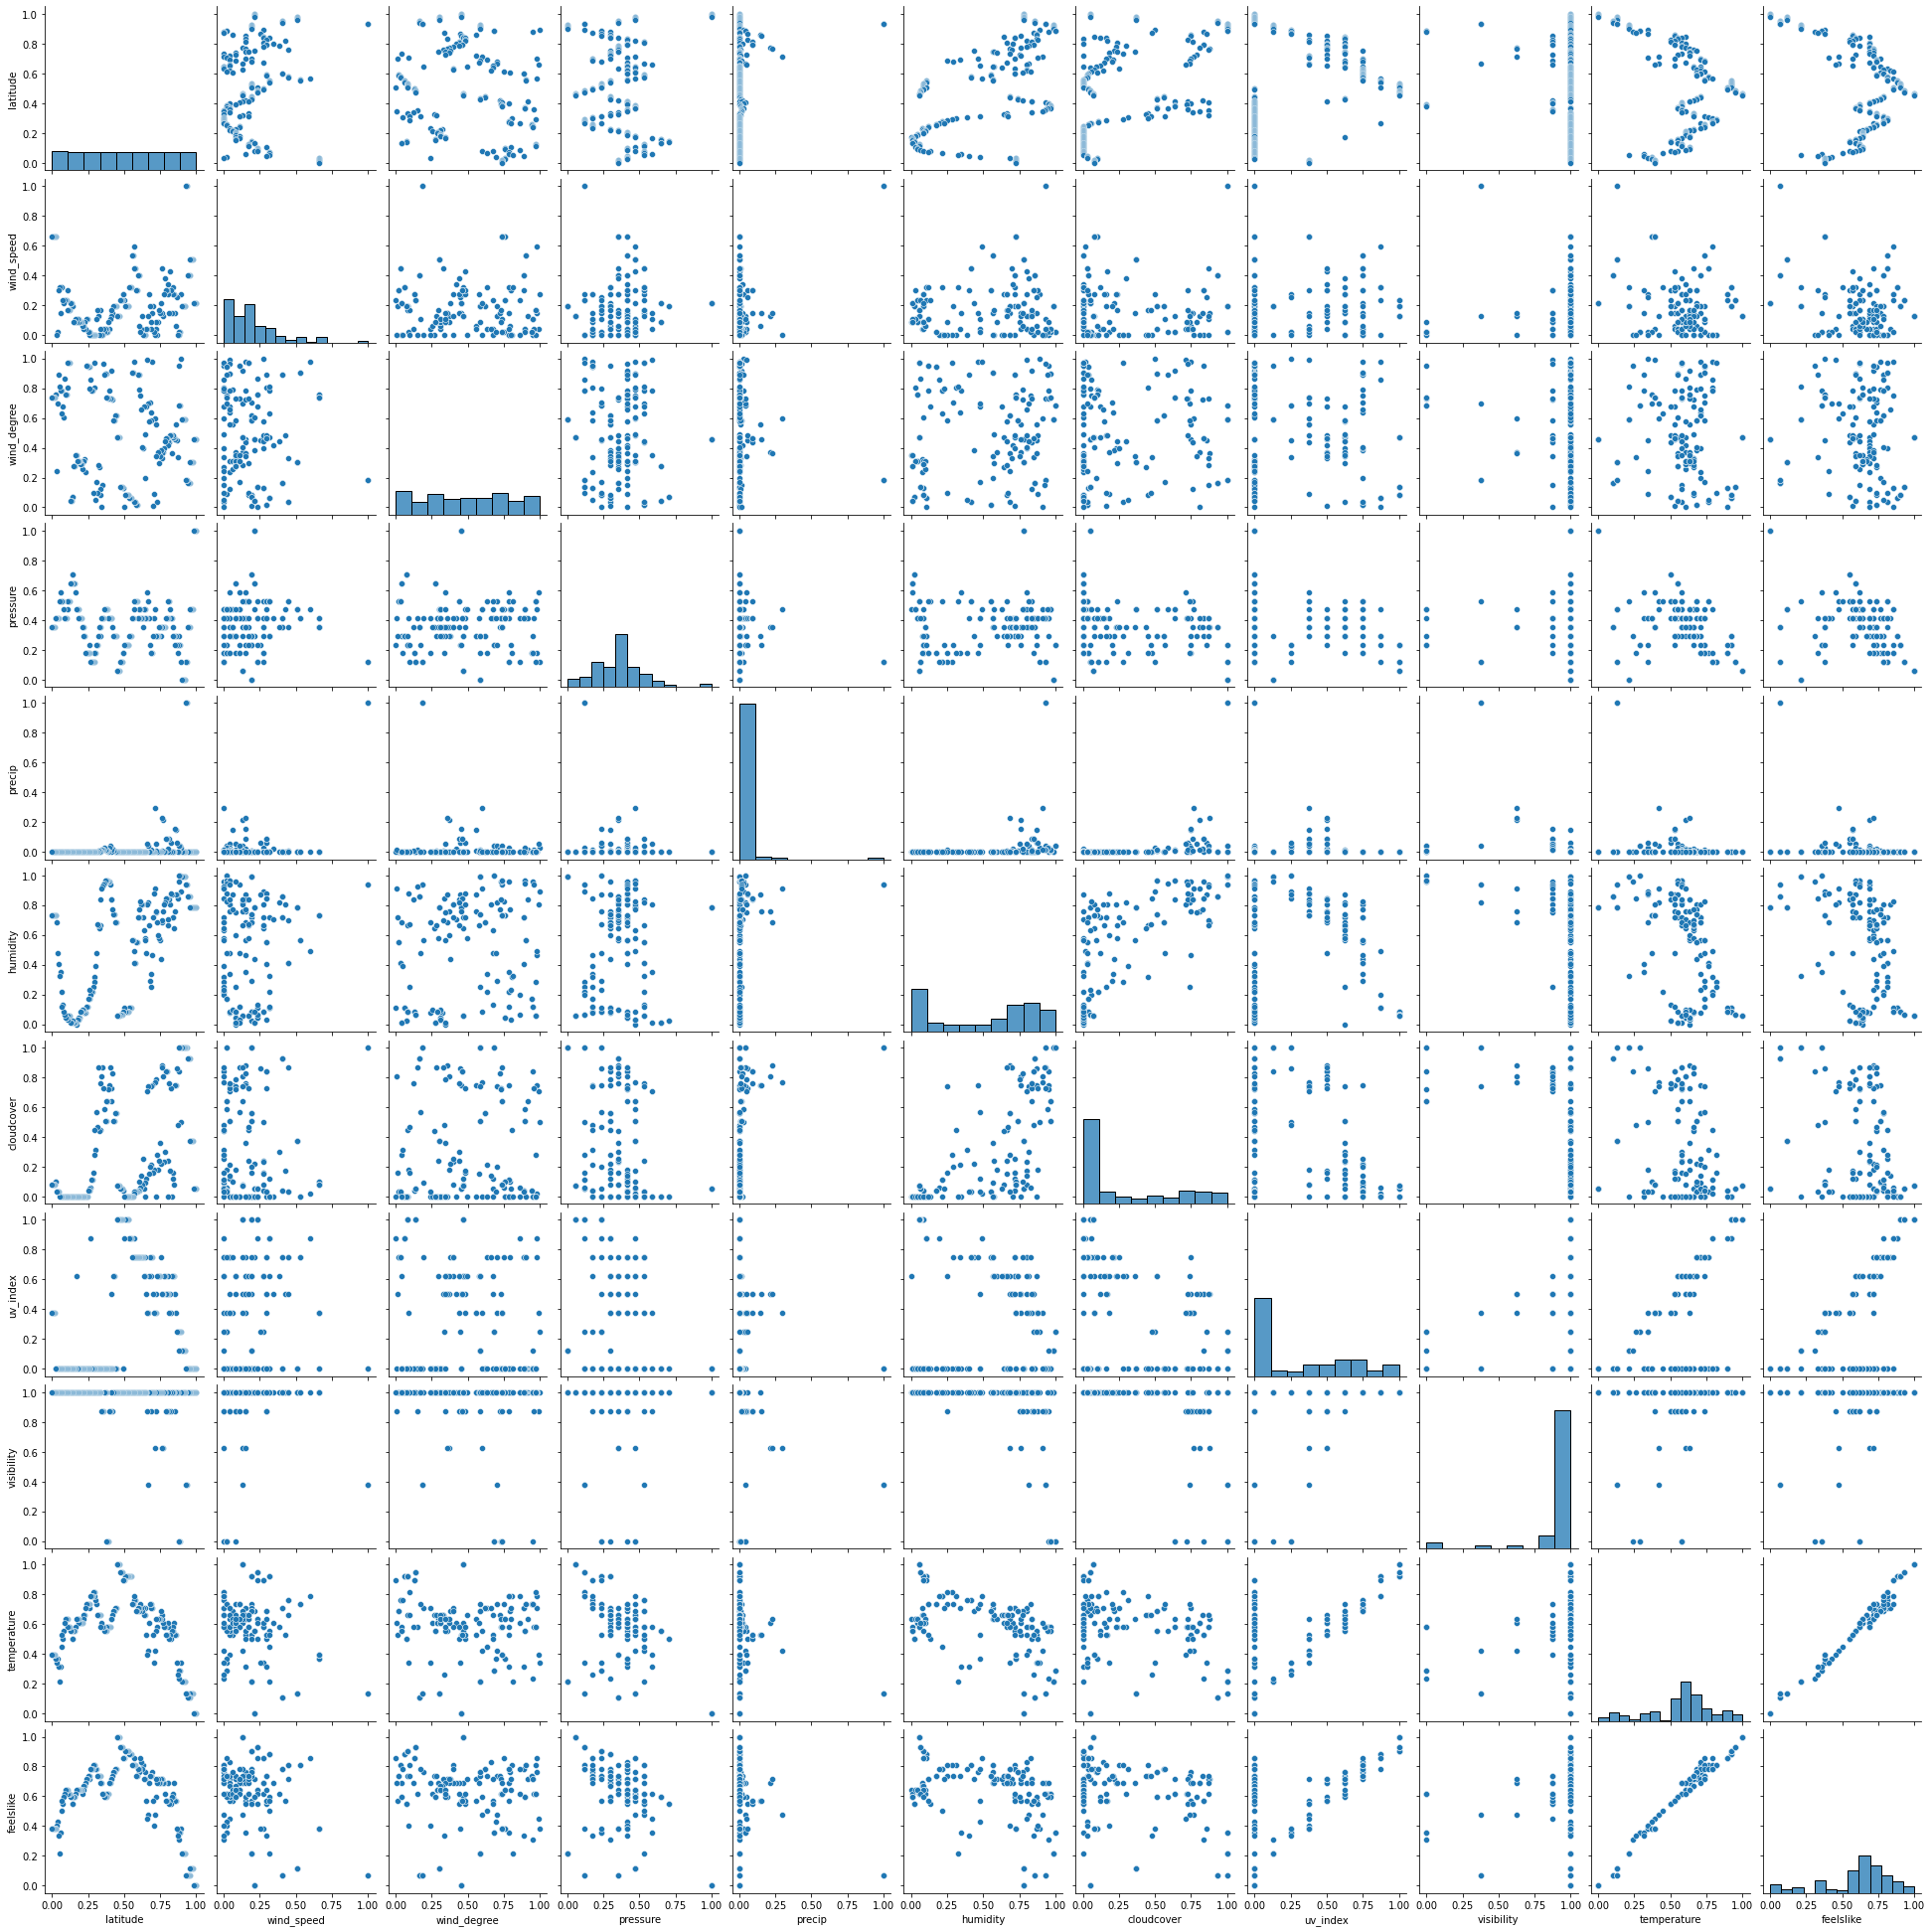

In [15]:
sns.pairplot(df_norm)

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike
latitude,0.084836,0.007421,-0.015350,-0.004537,0.007801,0.058922,0.048269,0.033977,-0.011180,-0.022091,-0.021492
wind_speed,0.007421,0.034028,-0.003261,0.002093,0.008468,0.008880,-0.001018,0.005425,0.001866,-0.012143,-0.014644
wind_degree,-0.015350,-0.003261,0.086307,0.000150,-0.003007,0.017926,0.007267,-0.019036,-0.008270,-0.007441,-0.005456
pressure,-0.004537,0.002093,0.000150,0.032282,-0.002698,0.003132,-0.016125,-0.015625,0.000967,-0.015355,-0.013456
precip,0.007801,0.008468,-0.003007,-0.002698,0.012801,0.008531,0.013912,-0.003018,-0.008780,-0.005911,-0.006680
humidity,0.058922,0.008880,0.017926,0.003132,0.008531,0.116772,0.083247,-0.008718,-0.024993,-0.043066,-0.037754
cloudcover,0.048269,-0.001018,0.007267,-0.016125,0.013912,0.083247,0.118624,-0.024730,-0.033224,-0.030240,-0.027905
uv_index,0.033977,0.005425,-0.019036,-0.015625,-0.003018,-0.008718,-0.024730,0.126169,0.009137,0.041867,0.042793
visibility,-0.011180,0.001866,-0.008270,0.000967,-0.008780,-0.024993,-0.033224,0.009137,0.041758,0.009484,0.008815
temperature,-0.022091,-0.012143,-0.007441,-0.015355,-0.005911,-0.043066,-0.030240,0.041867,0.009484,0.050409,0.050783


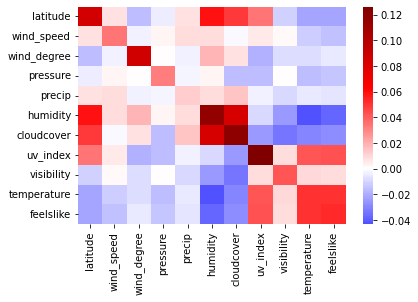

In [16]:
labels = list(df_norm.columns)
sns.heatmap(np.cov(np.array(df_norm).T), xticklabels=labels, yticklabels=labels, cmap='seismic', center=0)
pd.DataFrame(np.cov(np.array(df_norm).T), index=labels, columns=labels)

É possível notar uma significativa proporção inversa de temperatura/sensação térmica com a umidade e com a porcentagem de núvens no céu, e uma proporção direta dos targets com a índice de radiação UV.

## Modelo

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

training_subset_size = 0.2 #20% dos dados para o teste.

### Definindo treino/teste

#### Temperatura

In [18]:
indices = df.index
indices_training, indices_test = train_test_split(indices, test_size = training_subset_size, random_state = seed)

df_training = df.loc[indices_training]
df_test = df.loc[indices_test]

x_training = df_training.reindex(features, axis = 1).values
y_training_temp = df_training.reindex(target1, axis = 1).values
X_test = df_test.reindex(features, axis = 1).values
Y_test_temp = df_test.reindex(target1, axis = 1).values

#### Sensação térmica

In [19]:
indices = df.index
indices_training, indices_test = train_test_split(indices, test_size = training_subset_size, random_state = seed)

df_training = df.loc[indices_training]
df_test = df.loc[indices_test]

y_training_fl = df_training.reindex(target2, axis = 1).values
Y_test_fl = df_test.reindex(target2, axis = 1).values

### BaseLine para comparação

In [20]:
from sklearn.dummy import DummyRegressor

In [21]:
modelo_baseline_temp = DummyRegressor()
modelo_baseline_fl = DummyRegressor()

modelo_baseline_temp.fit(x_training, y_training_temp)
modelo_baseline_fl.fit(x_training, y_training_fl)

previsao_temp = modelo_baseline_temp.predict(x_training)
previsao_fl = modelo_baseline_fl.predict(x_training)

#### RMSE

In [22]:
y_true_temp = Y_test_temp
y_previsao_temp = previsao_temp = modelo_baseline_temp.predict(X_test)

RMSE_temp = mean_squared_error(y_true_temp, y_previsao_temp, squared=False)

print(f"O RMSE do modelo baseline, para temperatura, foi de {RMSE_temp} °C")

O RMSE do modelo baseline, para temperatura, foi de 9.034191387257687 °C


In [23]:
y_true_fl = Y_test_fl
y_previsao_fl = previsao_fl = modelo_baseline_fl.predict(X_test)

RMSE_fl = mean_squared_error(y_true_fl, y_previsao_fl, squared=False)

print(f"O RMSE do modelo baseline, para sensação térmica, foi de {RMSE_fl} °C")

O RMSE do modelo baseline, para sensação térmica, foi de 10.242786283420473 °C


O erro quadrado médio do modelo de baseline é considerável, já que os dados não se comportam como a linha.

O modelo baseline existe para comparar a eficácia do modelo de interpolação com uma linha de base.

### Floresta aleatória

In [24]:
from sklearn.ensemble import RandomForestRegressor as RFR

No processo de encontrar um modelo com o menor RMSE possível, a floresta aleatória obteve o melhor resultado, vê-se:

In [25]:
modelo_rf_temp = RFR(n_estimators=10, random_state=seed, n_jobs=4)
modelo_rf_fl = RFR(n_estimators=100, random_state=seed, n_jobs=4)

modelo_rf_temp.fit(x_training, y_training_temp.ravel())
modelo_rf_fl.fit(x_training, y_training_fl.ravel())

previsao_temp = modelo_rf_temp.predict(x_training)
previsao_feel = modelo_rf_fl.predict(x_training)

#### RMSE

In [44]:
y_true_temp = Y_test_temp.ravel()
y_previsao_temp = previsao_temp = modelo_rf_temp.predict(X_test)

RMSE_temp_rf = mean_squared_error(y_true_temp, y_previsao_temp, squared=False)

print(f"O RMSE do modelo Floresta aleatória, para temperatura, foi de {RMSE_temp_rf} °C")

O RMSE do modelo Floresta aleatória, para temperatura, foi de 1.2088955998880015 °C


In [45]:
y_true_fl = Y_test_fl.ravel()
y_previsao_fl = previsao_fl = modelo_rf_fl.predict(X_test)

RMSE_fl_rf = mean_squared_error(y_true_fl, y_previsao_fl, squared=False)

print(f"O RMSE do modelo Floresta aleatória, para temperatura, foi de {RMSE_fl_rf} °C")

O RMSE do modelo Floresta aleatória, para temperatura, foi de 1.5637555526908378 °C


#### Importância

In [28]:
from sklearn.inspection import permutation_importance

N_REPETICOES = 10

def R2_1param(modelo, x, y):
    """Computa o coef. de determinação quando hip. alt. não tem coef. linear."""
    y_pred = modelo.predict(x).ravel()
    y_true = (np.array(y)).ravel()
    return 1 - sum((y_true - y_pred) ** 2) / sum(y_true**2)

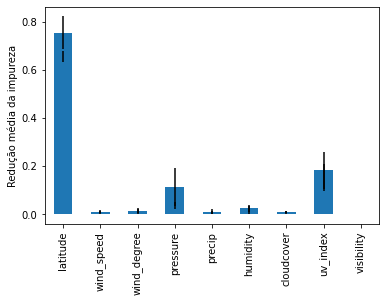

In [29]:
importancia_temp = modelo_rf_temp.feature_importances_
importancia_fl = modelo_rf_fl.feature_importances_

desvio_padrao_temp = np.std([arvore.feature_importances_ for arvore in modelo_rf_temp.estimators_], axis=0)
desvio_padrao_fl = np.std([arvore.feature_importances_ for arvore in modelo_rf_fl.estimators_], axis=0)

serie_importancia_temp = pd.Series(importancia_temp, index=features)
serie_importancia_fl = pd.Series(importancia_fl, index=features)

fig, axe = plt.subplots()

serie_importancia_temp.plot.bar(yerr=desvio_padrao_temp, ax=axe)
serie_importancia_fl.plot.bar(yerr=desvio_padrao_fl, ax=axe)

axe.set_ylabel("Redução média da impureza")
plt.show()

In [30]:
X_local = x_training
y_local_temp = y_training_temp
y_local_feel = y_training_fl

R2_temp = R2_1param(modelo_rf_temp, X_local, y_local_temp)
print(f"O R^2 da previsão temperature é de {R2_temp}\n")

r_temp = permutation_importance(
    modelo_rf_temp,
    X_local,
    y_local_temp,
    n_repeats=N_REPETICOES,
    random_state=seed,
    scoring=R2_1param,
)

for i in r_temp.importances_mean.argsort()[::-1]:
    if r_temp.importances_mean[i] - 2 * r_temp.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r_temp.importances_mean[i]:.3f}"
              f" +/- {r_temp.importances_std[i]:.3f}")

R2_feel = R2_1param(modelo_rf_fl, X_local, y_local_feel)
print(f"\n\nO R^2 da previsão feelslike é de {R2_feel}\n")

r_feel = permutation_importance(
    modelo_rf_fl,
    X_local,
    y_local_feel,
    n_repeats=N_REPETICOES,
    random_state=seed,
    scoring=R2_1param,
)

for i in r_feel.importances_mean.argsort()[::-1]:
    if r_feel.importances_mean[i] - 2 * r_feel.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r_feel.importances_mean[i]:.3f}"
              f" +/- {r_feel.importances_std[i]:.3f}")

O R^2 da previsão temperature é de 0.9989148961709279

latitude 0.156 +/- 0.011
uv_index 0.027 +/- 0.005
pressure 0.017 +/- 0.002
humidity 0.002 +/- 0.000
wind_degree 0.002 +/- 0.000
wind_speed 0.001 +/- 0.000
precip   0.001 +/- 0.000
cloudcover 0.001 +/- 0.000
visibility 0.000 +/- 0.000


O R^2 da previsão feelslike é de 0.9983801345066329

latitude 0.208 +/- 0.011
uv_index 0.030 +/- 0.006
pressure 0.009 +/- 0.002
humidity 0.003 +/- 0.001
precip   0.002 +/- 0.000
wind_degree 0.002 +/- 0.000
cloudcover 0.001 +/- 0.000
wind_speed 0.001 +/- 0.000
visibility 0.000 +/- 0.000


## Classificação

<AxesSubplot:>

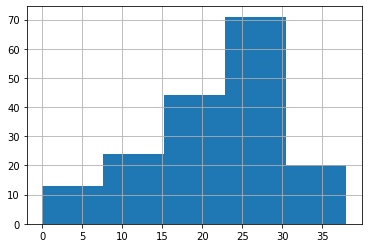

In [31]:
df["temperature"].hist(bins=5)

Usando o histograma podemos classificar as temperaturas

In [32]:
logic = df["temperature"] <= 5
print(len(df.loc[logic]),'Muito frio')
logic = (df["temperature"] > 5) & (df["temperature"] <= 16)
print(len(df.loc[logic]),'Frio')
logic = (df["temperature"] > 16) & (df["temperature"] <= 25)
print(len(df.loc[logic]),'Temperatura mediana')
logic = (df["temperature"] > 25) & (df["temperature"] <= 30)
print(len(df.loc[logic]),'Calor')
logic = (df["temperature"] > 30)
print(len(df.loc[logic]),'Muito calor')

13 Muito frio
26 Frio
77 Temperatura mediana
36 Calor
20 Muito calor


In [33]:
df['Temp Categórica'] = None

logic = df["temperature"] <= 5
df.loc[logic, 'Temp Categórica'] = 'Muito frio'
logic = (df["temperature"] > 5) & (df["temperature"] <= 16)
df.loc[logic, 'Temp Categórica'] = 'Frio'
logic = (df["temperature"] > 16) & (df["temperature"] <= 25)
df.loc[logic, 'Temp Categórica'] = 'Temperatura mediana'
logic = (df["temperature"] > 25) & (df["temperature"] <= 30)
df.loc[logic, 'Temp Categórica'] = 'Calor'
logic = (df["temperature"] > 30)
df.loc[logic, 'Temp Categórica'] = 'Muito Calor'
df

,latitude,wind_speed,wind_degree,pressure,precip,humidity,cloudcover,uv_index,visibility,temperature,feelslike,Temp Categórica
7,84.94,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
8,84.22,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
9,83.49,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
10,82.77,14,163,1022,0.0,80,5,1,10,0,-4,Muito frio
11,82.05,28,109,1013,0.0,80,37,1,10,5,1,Muito frio
...,...,...,...,...,...,...,...,...,...,...,...,...
174,-35.7,35,271,1012,0.0,75,10,1,10,14,12,Frio
175,-36.5,35,265,1011,0.0,75,8,4,10,15,12,Frio
176,-37.2,35,265,1011,0.0,75,8,4,10,15,12,Frio
177,-37.9,35,265,1011,0.0,75,8,4,10,15,12,Frio


Um gráfico de setores representa bem a distribuição dos dados categóricos

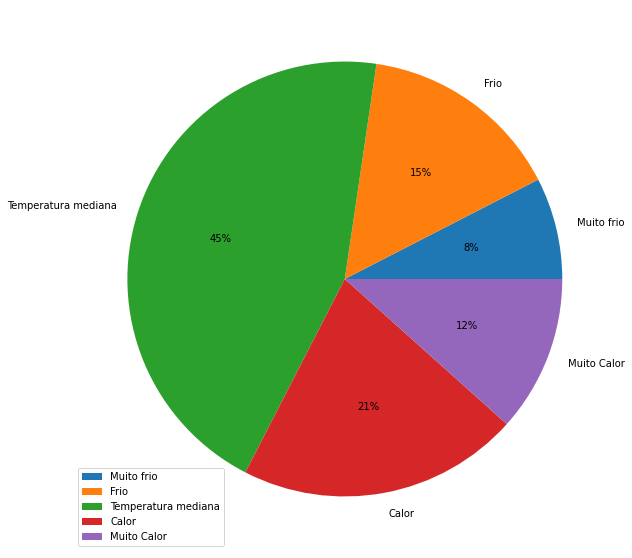

In [34]:
from collections import Counter

w_desc = pd.DataFrame.from_dict(Counter(list(df["Temp Categórica"])), orient="index")
w_desc.plot.pie(y=0, figsize=(10,10), autopct='%1.0f%%')
plt.legend(loc="lower left")
plt.axis('off')
plt.show()

<AxesSubplot:>

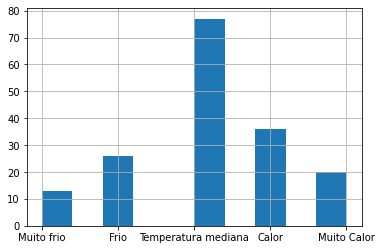

In [50]:
df["Temp Categórica"].hist()

## PCA
Para redução da dimensionalidade

In [35]:
from sklearn.decomposition import PCA

In [36]:
x = df_norm[features]
y = df_norm['temperature']

pca = PCA(n_components=3)
pca.fit(x)
x_pca = pca.transform(x)

In [37]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=training_subset_size, random_state=seed)

                PC1     PC2     PC3  temperature
PC1          1.0000 -0.0000 -0.0000      -0.5395
PC2         -0.0000  1.0000  0.0000       0.3679
PC3         -0.0000  0.0000  1.0000       0.1661
temperature -0.5395  0.3679  0.1661       1.0000


,PC1,PC2,PC3,temperature
7,0.194984,-0.084472,-0.149684,0.000000
8,0.192654,-0.086825,-0.149184,0.000000
9,0.190293,-0.089210,-0.148678,0.000000
10,0.187964,-0.091562,-0.148178,0.000000
11,0.405551,0.000199,-0.309209,0.131579
...,...,...,...,...
174,-0.135660,-0.492412,0.210066,0.368421
175,-0.179649,-0.169300,0.343972,0.394737
176,-0.181914,-0.171588,0.344458,0.394737
177,-0.184178,-0.173875,0.344943,0.394737


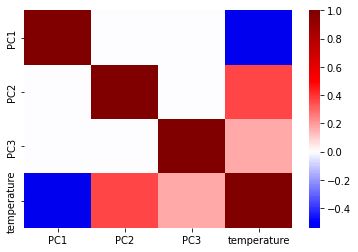

In [38]:
df_pca_train = pd.DataFrame(x_pca, columns=['PC1', 'PC2', 'PC3'], index=df.index)
df_pca_train['temperature'] = y
corrmat = df_pca_train.corr()
sns.heatmap(corrmat, cmap='seismic', center=0)
print(round(corrmat, 4))
df_pca_train

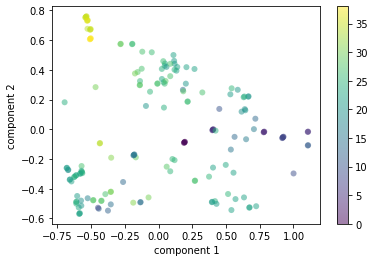

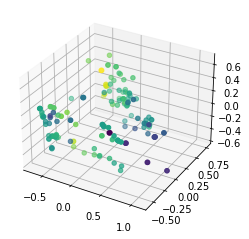

In [39]:
feat = 'temperature'

plt.scatter(x_pca[:, 0], x_pca[:, 1], edgecolor='none', alpha=0.5, c=df[feat].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=df[feat].values)

Nota-se uma leve clusterização

### Aplicando no modelo utilizado

In [40]:
modelo_rf_pca = RFR(random_state=seed)

modelo_rf_pca.fit(x_train_pca, y_train_pca)

# Utilizando o modelo para prever os dados
y_previsao_pca = modelo_rf_pca.predict(x_test_pca)

# Calculando o RMSE
RMSE_pca = mean_squared_error(y_test_pca, y_previsao_pca, squared=False)
RMSE_pca_sem_norm = RMSE_pca * (df["temperature"].max() - df["temperature"].min()) + df["temperature"].min()

print(f'O RMSE do modelo de floresta aleatoria com PCA foi de {RMSE_pca_sem_norm} °C\nEnquando o RMSE sem PCA resultou em {RMSE_temp_rf} °C\nE o RMSE do modelo baseline {RMSE_temp} °C')

O RMSE do modelo de floresta aleatoria com PCA foi de 3.402265631688894 °C
Enquando o RMSE sem PCA resultou em 1.2088955998880015 °C
E o RMSE do modelo baseline 9.034191387257687 °C


## Prevendo com o modelo treinado

In [41]:
df_prev = df.drop("temperature", axis=1)
df_prev = df_prev.drop("feelslike", axis=1)
df_prev = df_prev.drop("Temp Categórica", axis=1)

y_previsao_real_temp = modelo_rf_temp.predict(df_prev)
y_previsao_real_fl = modelo_rf_fl.predict(df_prev)

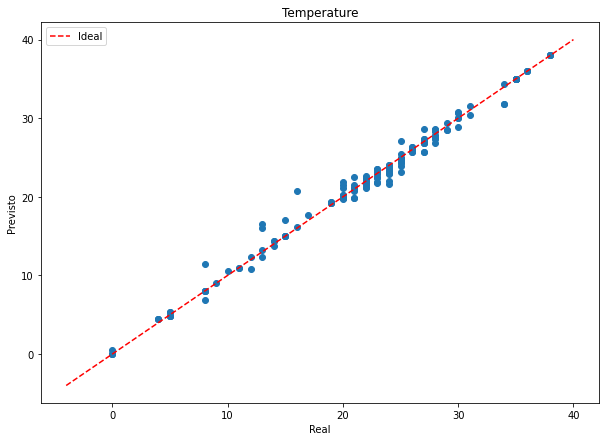

In [42]:
previsto = np.array(y_previsao_real_temp.reshape(-1,1))
real = np.array(df["temperature"]).reshape(-1,1)
                    
plt.figure(figsize=(10, 7))
plt.scatter(real, previsto)
plt.plot([-4,40], [-4,40], 'r--')
plt.legend(['Ideal'])
plt.ylabel("Previsto")
plt.xlabel("Real")
plt.title("Temperature")
plt.show()

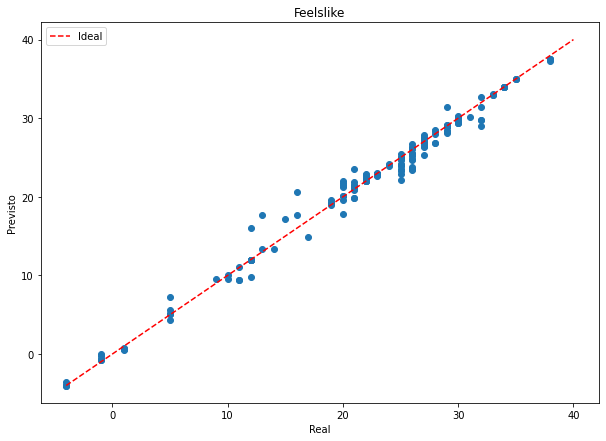

In [43]:
previsto = np.array(y_previsao_real_fl.reshape(-1,1))
real = np.array(df["feelslike"]).reshape(-1,1)
                    
plt.figure(figsize=(10, 7))
plt.scatter(real, previsto)
plt.plot([-4,40], [-4,40], 'r--')
plt.legend(['Ideal'])
plt.ylabel("Previsto")
plt.xlabel("Real")
plt.title("Feelslike")
plt.show()

Os modelos prevêem bem, se aproximam da linha ideal em Previsto x Real.